In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras as keras
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU, RNN
from keras.models import Sequential
from keras import optimizers


# Step 1. Loading data

In [2]:
# path must be specified relatively notebook 
PATH = "../data/eurusd_m1_202103.csv"
COLUMNS = ["offset", "open", "high", "low", "close"]
df_train = pd.read_csv(PATH, skipinitialspace=True, names = COLUMNS, index_col=False, sep=';')
df_train.shape
df_train.head(5)

,offset,open,high,low,close
0,0,1.20776,1.20783,1.20776,1.20783
1,100,1.20783,1.20791,1.20783,1.20789
2,200,1.20789,1.20802,1.20788,1.20798
3,300,1.20798,1.20802,1.20793,1.20793
4,400,1.20793,1.20798,1.20793,1.20796


In [3]:
# Enter in how much steps we will enroll the network.
# RNN/LSTM/GRU can be taught patterns over times series as big as the number of times you enrol them, and no bigger (fundamental limitation). 
# So by design these networks are deep/long to catch recurrent patterns.
Enrol_window = 100



# Step 2. Define auxilary routines



In [4]:
def load_data(datasetname, column, seq_len, normalize_window):
    # extract column from the data set
    data = datasetname.loc[:,column]

    sequence_length = seq_len + 1
    arr = []
    # split all data into sliding window blocks
    for index in range(len(data) - sequence_length):
        arr.append(data[index: index + sequence_length])
    
    if normalize_window:
        arr = normalize_windows(arr)

    arr = np.array(arr)

    # split all set into 2 parts - training set and test one
    pivot_point = int(round(0.9 * arr.shape[0]))
    train = arr[:pivot_point,:]
    np.random.shuffle(train)
    x_train = train[:,:-1]
    y_train = train[:,-1]
    x_test = arr[pivot_point:,:-1]
    y_test = arr[pivot_point:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test, pivot_point + sequence_length]

def normalize_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = []
        first = True
        base = 1
        min_value = 1
        max_value = 1
        for p in window:
            if first:
                base = p
                min_value = base
                max_value = base
                first = False
            min_value = min(min_value, p)
            max_value = max(max_value, p)
        offset =  float(base) - float(min_value)
        range = float(max_value) - float(min_value)
        if (min_value == max_value):
            range = 1
        for p in window:
            normalised_window.append((float(p) - float(min_value))/ range)
        normalised_data.append(normalised_window)
    return normalised_data

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white') 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    plt.plot(predicted_data, label='Prediction') 
    plt.legend() 
    plt.show() 
    

print ('functions defined')

functions defined


# Step 3. Normalize data

split pont = 659


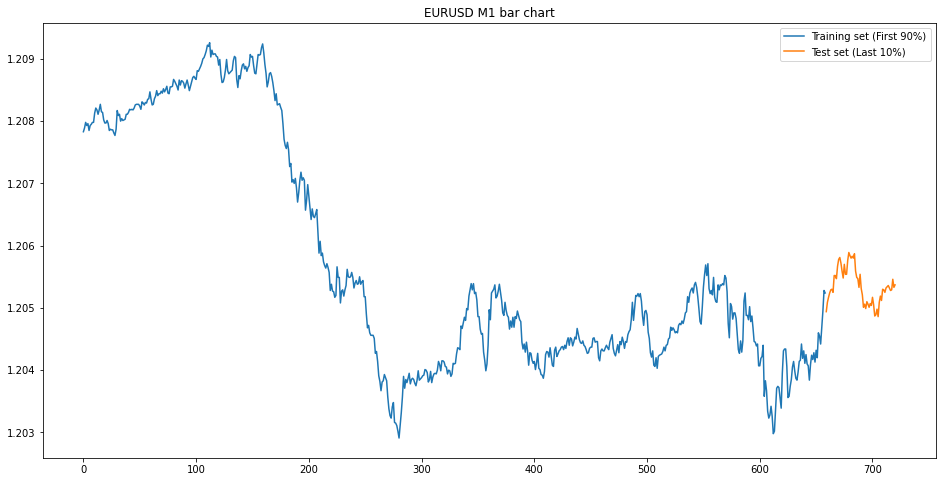

In [5]:
# A label is the thing we're predicting
# A feature is an input variable, in this case a stock price

feature_train, label_train, feature_test, label_test, split = load_data(df_train, 'close', Enrol_window, True)
print(f'split pont = {split}')
df_train["close"][:split].plot(figsize=(16,8),legend=True)
df_train["close"][split:].plot(figsize=(16,8),legend=True) # 10% is used for thraining data which is approx 2017 data
plt.legend(['Training set (First 90%)','Test set (Last 10%)'])
plt.title('EURUSD M1 bar chart')
plt.show()

# Step 4. Define model

In [6]:
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(GRU(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')

print ('model compiled')

print (model.summary())

model compiled
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100, 50)           7950      
_________________________________________________________________
dropout (Dropout)            (None, 100, 50)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               45600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 53,651
Trainable params: 53,651
Non-trainable params: 0
_________________________________________________________________
None


# Step 5. Train and calculate predicts

In [7]:
model.fit(feature_train, label_train, batch_size=512, epochs=15, validation_data = (feature_test, label_test))

Epoch 1/15
2/2 [==============================] - 6s 2s/step - loss: 0.2866 - val_loss: 0.3925
Epoch 2/15
2/2 [==============================] - 1s 128ms/step - loss: 0.1430 - val_loss: 0.1470
Epoch 3/15
2/2 [==============================] - 1s 136ms/step - loss: 0.0590 - val_loss: 0.0187
Epoch 4/15
2/2 [==============================] - 1s 136ms/step - loss: 0.0323 - val_loss: 0.0119
Epoch 5/15
2/2 [==============================] - 1s 135ms/step - loss: 0.0499 - val_loss: 0.0164
Epoch 6/15
2/2 [==============================] - 1s 135ms/step - loss: 0.0523 - val_loss: 0.0054
Epoch 7/15
2/2 [==============================] - 1s 144ms/step - loss: 0.0348 - val_loss: 0.0082
Epoch 8/15
2/2 [==============================] - 1s 151ms/step - loss: 0.0247 - val_loss: 0.0246
Epoch 9/15
2/2 [==============================] - 1s 118ms/step - loss: 0.0251 - val_loss: 0.0414
Epoch 10/15
2/2 [==============================] - 1s 140ms/step - loss: 0.0269 - val_loss: 0.0475
Epoch 11/15
2/2 [=====

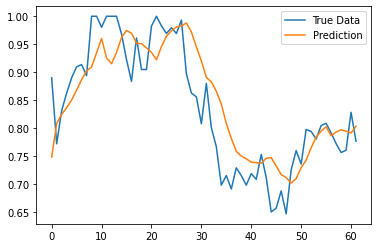

In [8]:
predicted_price = model.predict(feature_test)
plot_results(predicted_price, label_test)